In [519]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable


## Classificação de imagens de tempo

**Classificação de Imagens**

> Classificação de imagens de tempo utilizando técnicas clássicas de Processamento Digital de Imagens e treinar classificadores para predição dos atributos.

In [520]:
### Módulos necessários
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import imutils
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics,svm
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from sklearn.preprocessing import MaxAbsScaler
from tensorflow import keras

- **Preparando o dataset**

> Neste primeiro momento há necessidade de observar as imagens do dataset e organizá-las em uma estrutura de dados adequada para que seus atributos possam ser extraídos. há então a necessidade de carregar o conjunto de imagens via código.

In [521]:
def load_data(datadir, classes, img_size=100):
    training_data = []
    label = []
    for classe in range(len(classes)):
        path = os.path.join(datadir, classes[classe])
        shufled_list  = list(os.listdir(path))
        #shuffle(shufled_list)
        for img in shufled_list:
            img_array = cv2.imread(os.path.join(path, img))
            if img_array is None:
                continue
            img_array = cv2.resize(img_array, (img_size, img_size))
            #img_array = cv2.resize(img_array, (img_size, img_size)).flatten()

            training_data.append(img_array)
            label.append(classe)

    return training_data, label

In [1]:
data, label = load_data('imagens/', ['cloudy','rain','shine','sunrise'])

NameError: name 'load_data' is not defined

In [523]:
len(data)

1123

- O código acima realiza a implementação de uma função que recebe 3 argumentos: o diretório que contem as pastas das imagens, uma lista de string que contém o nome das classes que devem ser reconhecidas e um parâmetro default que é o  tamanho da imagem que será utilizado em todo o processo. 


- São definidas duas listas vazias training_data e label. Em ***training_data*** serão armazenadas as imagens e em ***label*** serão definidos números que representam cada classe. Deste modo, é possível saber a classe da imagem que estiver na posição 5 da lista training_data observando o número contido da quinta posição da lista label.

- Um loop for é realizado para iterar sobre as possíveis classes. Assim a variável classe, definida no loop, poderá assumir valores variando de  0 até 3, em que 0 representa classe **'cloudy'** e 3 representa a classe **'sunrise'**. Na variável path é armazenada a string que contem o caminho para pasta de imagens da classe específica, conforme iteração do loop for e na estrutura shufled_list são contidas strings que são os caminhos de cada imagem da classe, já com um primeiro embaralhamento.

### Pré-Processamento

In [524]:
### Pré-Processamento

#### Blur

##### Filtro de média
blur_data = []
for i in range(len(data)):
    blur_img = cv2.blur(data[i], ksize=(3,3))
    blur_data.append(blur_img)

##### GaussianBlur
gaussian_data = []
for i in range(len(data)):
    gaussian_img = cv2.GaussianBlur(src=data[i], ksize=(15,15),sigmaX=0)
    gaussian_data.append(gaussian_img)

#### Equalização do histograma

##### HSV
Eq_data = []
for i in range(len(data)):
    img = data[i]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    canais =  cv2.split(hsv)
    cv2.equalizeHist(canais[2],canais[2])
    cv2.merge(canais, hsv)
    Eq_data.append(cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR))


#### Filtro	Máscara de Desaguçamento

# Filtro máscara de desaguçamento, ou	filtro	de realce
realce_data = []
for i in range(len(data)):
    imgOriginal = data[i]
    imgSuavizada = cv2.GaussianBlur(imgOriginal, (13,13), 3)
    imgDetalhes = 3 * cv2.subtract(imgOriginal, imgSuavizada)
    imgRealcada = cv2.add(imgOriginal, imgDetalhes)
    realce_data.append(imgRealcada)

### Normalização dos dados

In [525]:
data_norm = [i/255 for i in data]
HSV_norm = [i/255 for i in Eq_data]
realce_norm = [i/255 for i in realce_data]

### Divisão dos dados


In [526]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, label, test_size=0.3, random_state=15, stratify= label)

### Data Augumentation

In [527]:
#Função retirada do trailhead
datagen = keras.preprocessing.image.ImageDataGenerator(
            zoom_range = 0.1, # Aleatory zoom
            rotation_range= 15, 
            width_shift_range=0.1,  # horizontal shift
            height_shift_range=0.1,  # vertical shift
            horizontal_flip=True,  
            vertical_flip=True)
datagen.fit(X_train)

### Alteração do formato das labels

In [528]:
categorical_y_train = keras.utils.to_categorical(y_train)
categorical_y_test = keras.utils.to_categorical(y_test)

### Definição da rede neural

In [529]:
def get_CNN(X, y, epochs):
    classifier = keras.models.Sequential()

    classifier.add(keras.layers.Conv2D(64, (5, 5), input_shape=(100, 100, 3), activation='relu'))
    classifier.add(keras.layers.MaxPool2D(pool_size=(3, 3)))
    classifier.add(keras.layers.BatchNormalization())
    
    classifier.add(keras.layers.Conv2D(64, (5, 5),activation='relu'))
    classifier.add(keras.layers.MaxPool2D(pool_size=(3, 3)))
    classifier.add(keras.layers.BatchNormalization())
    
    classifier.add(keras.layers.Conv2D(64, (5, 5),activation='relu'))
    classifier.add(keras.layers.MaxPool2D(pool_size=(3, 3)))
    classifier.add(keras.layers.BatchNormalization())
    classifier.add(keras.layers.Flatten())

    classifier.add(keras.layers.Dense(units=256, activation='relu'))
    classifier.add(keras.layers.Dropout(0.1))
    classifier.add(keras.layers.Dense(units=256, activation='relu'))
    classifier.add(keras.layers.Dropout(0.1))
    classifier.add(keras.layers.Dense(units=256, activation='relu'))
    classifier.add(keras.layers.Dropout(0.1))

    classifier.add(keras.layers.Dense(units=4, activation='softmax'))
    
    classifier.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    classifier.fit(X, y, batch_size=10, epochs=epochs)
    
    return classifier

### Resultados

In [530]:
def get_confusion_matrix(y_true, y_pred, modelo):
    labels = ['cloudy','rain','shine','sunrise']
    cm = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues').set(title=modelo, ylabel='True Label', xlabel='Predicted Label')

In [531]:
CNN = get_CNN(np.array(X_train), categorical_y_train, 200)

Epoch 1/200
79/79 [==============================] - 7s 73ms/step - loss: 0.7654 - accuracy: 0.7099
Epoch 2/200
79/79 [==============================] - 6s 72ms/step - loss: 0.6099 - accuracy: 0.7863
Epoch 3/200
79/79 [==============================] - 6s 71ms/step - loss: 0.5395 - accuracy: 0.8104
Epoch 4/200
79/79 [==============================] - 6s 71ms/step - loss: 0.4454 - accuracy: 0.8511
Epoch 5/200
79/79 [==============================] - 6s 71ms/step - loss: 0.3836 - accuracy: 0.8626
Epoch 6/200
79/79 [==============================] - 6s 71ms/step - loss: 0.3944 - accuracy: 0.8651
Epoch 7/200
79/79 [==============================] - 6s 70ms/step - loss: 0.3923 - accuracy: 0.8664
Epoch 8/200
79/79 [==============================] - 6s 71ms/step - loss: 0.3260 - accuracy: 0.8842
Epoch 9/200
79/79 [==============================] - 6s 71ms/step - loss: 0.3271 - accuracy: 0.8791
Epoch 10/200
79/79 [==============================] - 5s 67ms/step - loss: 0.3484 - accuracy: 0.8715

79/79 [==============================] - 4s 47ms/step - loss: 0.0353 - accuracy: 0.9860
Epoch 163/200
79/79 [==============================] - 4s 48ms/step - loss: 0.0643 - accuracy: 0.9847
Epoch 164/200
79/79 [==============================] - 4s 47ms/step - loss: 0.0370 - accuracy: 0.9885
Epoch 165/200
79/79 [==============================] - 4s 47ms/step - loss: 0.1039 - accuracy: 0.9644
Epoch 166/200
79/79 [==============================] - 4s 47ms/step - loss: 0.0348 - accuracy: 0.9911
Epoch 167/200
79/79 [==============================] - 4s 47ms/step - loss: 0.0464 - accuracy: 0.9885
Epoch 168/200
79/79 [==============================] - 4s 47ms/step - loss: 0.0813 - accuracy: 0.9746
Epoch 169/200
79/79 [==============================] - 4s 47ms/step - loss: 0.0277 - accuracy: 0.9911
Epoch 170/200
79/79 [==============================] - 4s 47ms/step - loss: 0.0223 - accuracy: 0.9936
Epoch 171/200
79/79 [==============================] - 4s 47ms/step - loss: 0.0578 - accuracy: 0

In [538]:
# #model
# CNN.save("best_classifier.h5")
# model_json = CNN.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# CNN.save_weights("model.h5")
# print("Saved model to disk")

Saved model to disk


In [532]:
y_pred = CNN.predict(np.array(X_test))

11/11 [==============================] - 0s 28ms/step


In [533]:
list_pred = [np.argmax(i) for i in y_pred]

In [534]:
metrics.accuracy_score(y_test, list_pred)

0.9406528189910979

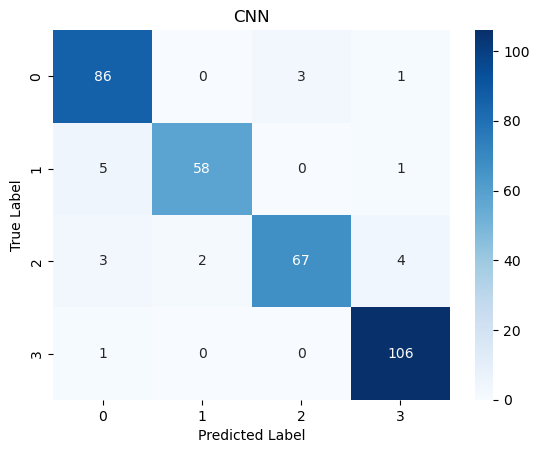

In [535]:
get_confusion_matrix(y_true=y_test, y_pred=list_pred, modelo='CNN')